In [1]:
import sys
sys.path.insert(0, '../..')

# general
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

sns.set()
warnings.filterwarnings("ignore")

# local
from sklearn_crfsuite import metrics
from core.stats import Statistics
from core.utils import load_dataset
from core.plots import plot_histogram, plot_learning_curve
from core.learning import LearningAnalyser
from core.reports import (
    compute_user_error,
    generate_comparison_report,
    generate_test_groups_comparison_report,
    generate_learning_report
)
from core.dataset import DatasetAnalyser, DatasetGroup

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

from core.latex import create_latex_tables_generator

import numpy as np
np.random.seed(3453562)

# 1. General statistics
## 1.1. Read data

In [2]:
df = load_dataset('../../data/ner/ner-dataset.csv')

### 1.1.1. Parse the attribute tags in IOB form

In [3]:
df['annotation__output'] = df['annotation__output'].apply(ast.literal_eval)
df['reference__output'] = df['reference__output'].apply(ast.literal_eval)

### 1.1.2. Simplify the beggining and inside tags

In [4]:
df['annotation__output'] = df['annotation__output'].apply(lambda tags:[t.split('-')[0] for t in tags])
df['reference__output'] = df['reference__output'].apply(lambda tags:[t.split('-')[0] for t in tags])

## 1.2. Statistics

In [5]:
stats = Statistics(df)

### 1.2.1. General

In [6]:
stats.general

,value
metric,
total_annotations,8043
unique_items,1999
unique_users,140
total_annotation_time,22h 44m 17s


### 1.2.2. Annotations per item

In [7]:
stats.annotations_per_item

,data__item_id
count,1999.000000
mean,4.023512
std,1.897775
min,1.000000
25%,3.000000
50%,3.000000
75%,5.000000
max,13.000000


### 1.2.3. Annotations per user

In [8]:
stats.annotations_per_user

,user__id
count,140.000000
mean,57.450000
std,45.305728
min,11.000000
25%,50.000000
50%,50.000000
75%,50.000000
max,350.000000


### 1.2.4. Average annotation time over time

,value
index,
10,24.026066
20,19.773098
30,21.773705
40,19.934701
60,15.584794
70,15.125309
80,18.176004
90,10.956556


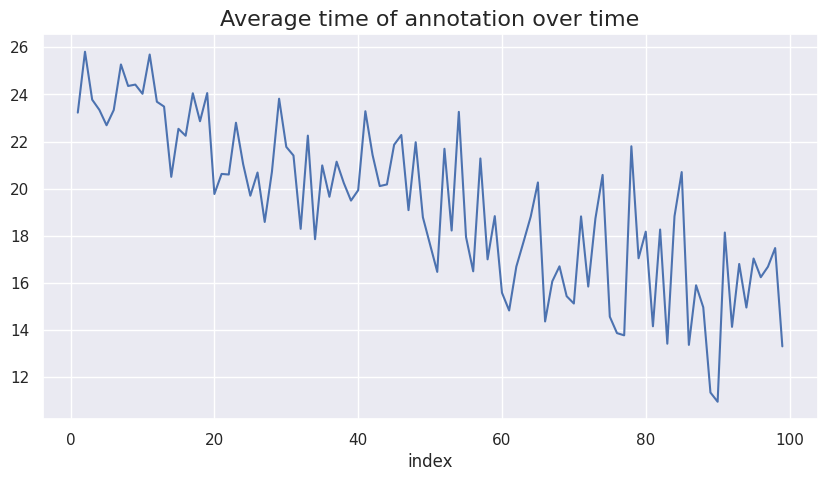

In [9]:
plt.figure(figsize=(10, 5))
plt.title("Average time of annotation over time", fontsize=16)
df_times = stats.average_time_per_annotation
df_times['value'].plot()
df_times[df_times.index % 10 == 0]

# 2. Confidence intervals
## 2.1. Compute user's annotation quality metrics
- In this section we aggregate the raw result to compute the quality metrics value per user
- To measure the quality of user's annotation we use: accuracy, recall, f1 and precision metrics
- Mean error is computed for each user in each test_group separately.<br/>
This way we can check how each user did in each test conditions

In [10]:
METRICS_COLUMNS = ["f1", "precision", "recall", "annotation_time", "count"]
LABELS = ["Geopolitical", "Geographical", "Organization", "Time", "Person"]

In [11]:
def metrics_function(y_true: pd.Series, y_pred: pd.Series):
    return {
        'precision': metrics.flat_precision_score(y_true, y_pred, average='weighted', labels=LABELS),
        'recall': metrics.flat_recall_score(y_true, y_pred, average='weighted', labels=LABELS),
        'f1': metrics.flat_f1_score(y_true, y_pred, average='weighted', labels=LABELS)
    }
  
    
df_user_error = compute_user_error(df, metrics_function)

## 2.2. Compute confidence intervals for test groups
In this section we compute the confidence intervals for the percentage quality change between the control group and each of the test groups.

In [12]:
dataset = DatasetAnalyser(df_user_error, METRICS_COLUMNS)

### 2.2.1. Compering: test groups vs control group

In [13]:
df_ci_h1, df_percentage_ci_h1, df_p_value_h1, df_cohen_d_h1 = generate_comparison_report(dataset)

#### Confidence intervals

In [14]:
df_ci_h1

f1  precision    recall  \
group_name              quantile                                  
high quality feedback   0.05      0.001003   0.013637 -0.048212   
                        0.5       0.090181   0.099019  0.048468   
                        0.95      0.180493   0.184083  0.147876   
low quality feedback    0.05     -0.126602  -0.097989 -0.171895   
                        0.5       0.001310   0.033578 -0.034727   
                        0.95      0.133361   0.167029  0.106864   
medium quality feedback 0.05     -0.118958  -0.088891 -0.151332   
                        0.5      -0.003757   0.028239 -0.038423   
                        0.95      0.107371   0.142884  0.074543   

                                  annotation_time      count  
group_name              quantile                              
high quality feedback   0.05            -6.199669 -11.799356  
                        0.5             -1.280678   1.088394  
                        0.95             3.655094  15.706250  
low quality feedback    0.05           -13.369562 -14.944737  
                        0.5             -4.887967  -2.346947  
                        0.95             3.767264  10.139474  
medium quality feedback 0.05            -6.049794  -0.823246  
                        0.5              0.277411  14.242298  
                        0.95             6.720325  31.387807

#### Percentage confidence intervals

In [15]:
df_percentage_ci_h1

f1  precision    recall  \
group_name              quantile                                  
high quality feedback   0.05      0.003180   0.039503 -0.131356   
                        0.5       0.285847   0.286842  0.132054   
                        0.95      0.572109   0.533259  0.402897   
low quality feedback    0.05     -0.418756  -0.314550 -0.499071   
                        0.5       0.004334   0.107786 -0.100824   
                        0.95      0.441112   0.536173  0.310265   
medium quality feedback 0.05     -0.237790  -0.178592 -0.272679   
                        0.5      -0.007509   0.056736 -0.069232   
                        0.95      0.214630   0.287071  0.134315   

                                  annotation_time     count  
group_name              quantile                             
high quality feedback   0.05            -0.255762 -0.209487  
                        0.5             -0.052833  0.019323  
                        0.95             0.150788  0.278850  
low quality feedback    0.05            -0.470080 -0.366293  
                        0.5             -0.171863 -0.057523  
                        0.95             0.132459  0.248517  
medium quality feedback 0.05            -0.232675 -0.021166  
                        0.5              0.010669  0.366175  
                        0.95             0.258464  0.806994

#### p-value

In [16]:
df_p_value_h1

,f1,precision,recall,annotation_time,count,group_name
0,0.9517,0.9706,0.7833,0.3318,0.5199,high quality feedback
0,0.4993,0.6501,0.3454,0.1809,0.3802,low quality feedback
0,0.4786,0.6535,0.2939,0.5219,0.9374,medium quality feedback


#### Cohen's D

In [17]:
df_cohen_d_h1

,f1,precision,recall,annotation_time,count,group_name
0,0.398785,0.451203,0.191546,-0.107238,0.032964,high quality feedback
0,0.005384,0.132243,-0.134467,-0.296146,-0.098007,low quality feedback
0,-0.017009,0.124161,-0.169614,0.021804,0.362662,medium quality feedback


#### Ploting histograms for the difference: test groups vs control group

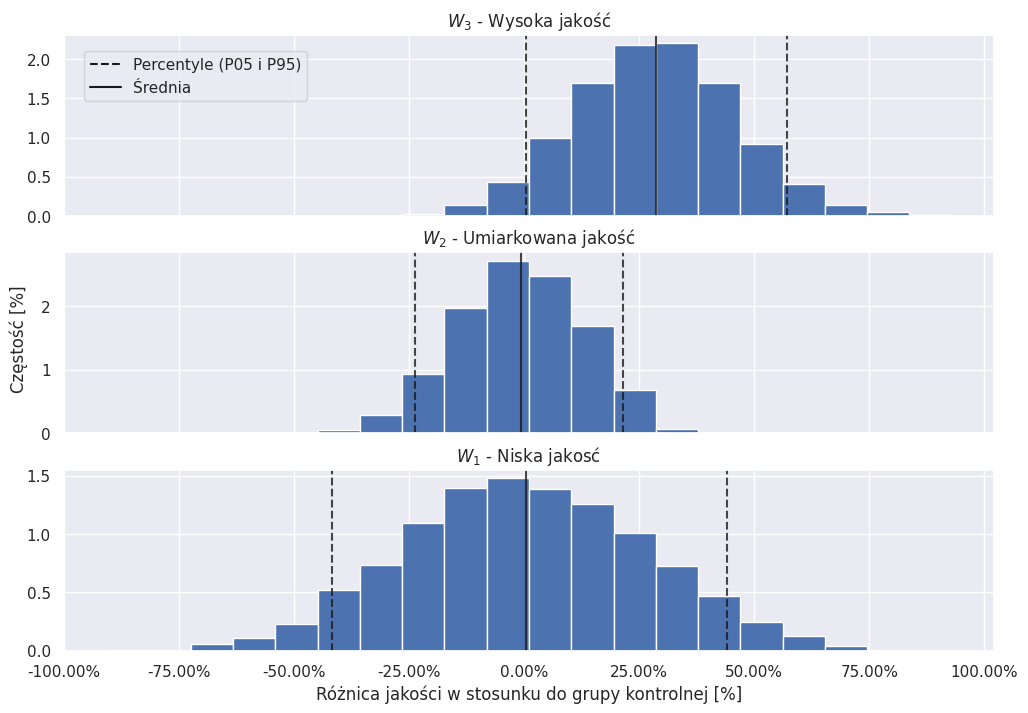

In [18]:
metric_index = 0
plot_histogram(dataset, metric_index)

### 2.2.2. Comparing: test groups with each other

In [19]:
df_ci_h2, df_p_value_h2, df_cohen_d_h2 = generate_test_groups_comparison_report(dataset)

#### Confidence interval

In [20]:
df_ci_h2

f1  precision    recall  annotation_time     count
group_name  quantile                                                          
high_low    0.05     -0.245931  -0.320815 -0.270853        -0.237945 -0.329661
            0.5       0.281514   0.179056  0.232878         0.119030  0.076847
            0.95      0.789970   0.646528  0.717497         0.473475  0.463954
high_medium 0.05     -0.075998  -0.108591 -0.143385        -0.385658 -0.885902
            0.5       0.293356   0.230106  0.201286        -0.063502 -0.346852
            0.95      0.671496   0.579267  0.554284         0.268632  0.128403
medium_low  0.05     -0.485256  -0.531036 -0.411913        -0.208135 -0.071714
            0.5      -0.011843  -0.051050  0.031592         0.182533  0.423699
            0.95      0.455834   0.411810  0.465768         0.574756  0.971208

#### p-value

In [21]:
df_p_value_h2

,f1,precision,recall,annotation_time,count,group_name
0,0.8084,0.7270,0.7760,0.7110,0.6310,high_low
0,0.9022,0.8624,0.8276,0.3764,0.1233,high_medium
0,0.4937,0.4363,0.5488,0.7854,0.9159,medium_low


#### Cohen's D

In [22]:
df_cohen_d_h2

,f1,precision,recall,annotation_time,count,group_name
0,1.273811,0.849663,1.117918,0.762683,0.456390,high_low
0,1.881759,1.576882,1.393817,-0.464130,-1.636778,high_medium
0,-0.056982,-0.245310,0.162388,1.088091,1.872809,medium_low


# 3. Analyse learning curve

In [23]:
def get_annotation_eval(row):
    return metrics.flat_f1_score(
        [row['reference__output']], [row['annotation__output']],
        average='weighted',
        labels=LABELS
    )

df['annotation_eval'] = df.apply(get_annotation_eval, axis=1)
df_high = df.query("test_group == 'high quality feedback'")

In [24]:
learning = LearningAnalyser(df_high)

#### Learning curve stats

In [25]:
learning_report = generate_learning_report(learning)
learning_report

,Metryka,Wartość
0,$\alpha$,-0.0
1,$\beta$,0.109
2,$\alpha_r$,-0.26%
3,$\beta_r$,+35.44%


#### Learning curve plot

In [26]:
# styling fix
learning_report['Wartość'] = learning_report['Wartość'].astype(str).str.replace(".", ",")

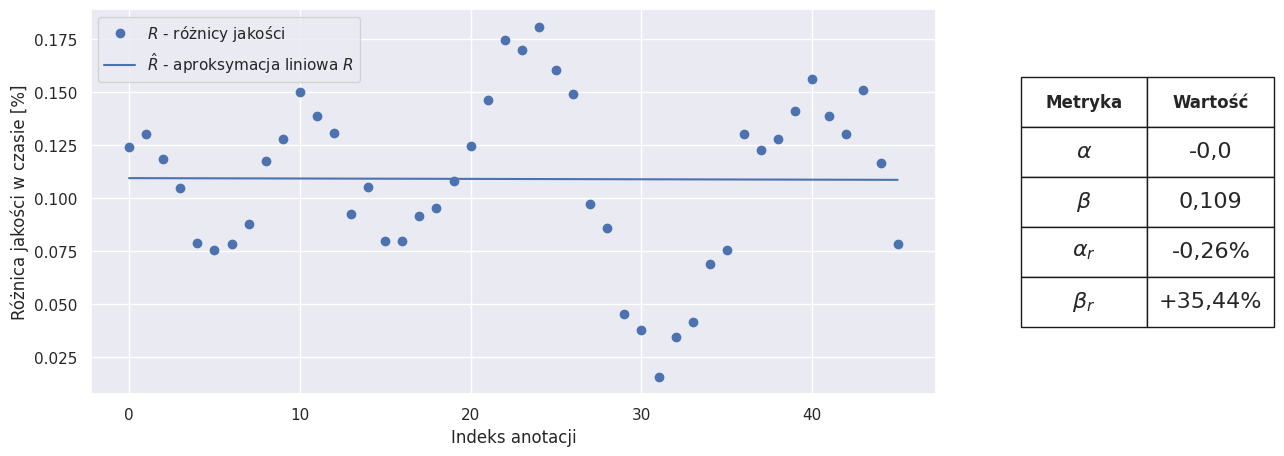

In [27]:
plot_learning_curve(learning, learning_report)

## Generate latex tables

In [28]:
latex_generator = create_latex_tables_generator(
    df_percentage_ci_h1=df_percentage_ci_h1,
    df_p_value_h1=df_p_value_h1,
    df_cohen_d_h1=df_cohen_d_h1,
    df_ci_h2=df_ci_h2,
    df_p_value_h2=df_p_value_h2,
    df_cohen_d_h2=df_cohen_d_h2
)

In [29]:
print(latex_generator.get_results_table("f1"))


\begin{table}[H]
\centering
\caption{}
\label{tab:my-table}
\begin{tabular}{cccccc}
\rowcolor[HTML]{EFEFEF} 
\multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\textbf{Warunek}} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$P_{05}$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$\mu$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$P_{95}$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$p$} &
  \boldmath$d$ \\ \hline
\rowcolor[HTML]{EFEFEF} 
\multicolumn{6}{c}{\cellcolor[HTML]{EFEFEF}Hipoteza $H_1$ -- zmiana w metryce XXXX}                                                                                                        \\ \hline
        \multicolumn{1}{c|}{$W_1$} & \multicolumn{1}{c|}{+0.32\%} & \multicolumn{1}{c|}{+28.58\%} & \multicolumn{1}{c|}{+57.21\%} & \multicolumn{1}{c|}{0.9517} & 0.4 \\ \hline\multicolumn{1}{c|}{$W_2$} & \multicolumn{1}{c|}{-23.78\%} & \multicolumn{1}{c|}{-0.75\%} & \multicolumn{1}{c|}{+21.46\%} & \multicolumn{1}{c|}{